* distribution of similarity scores
* pull out covid specific narratives with keyword based approach and map to historical narratives
* subtopics of top tweets

https://www.machinelearningplus.com/nlp/cosine-similarity/#2whatiscosinesimilarityandwhyisitadvantageous

In [1]:
import pandas as pd
import numpy as np
from scipy import spatial

In [2]:
glove_file = 'glove.twitter.27B.200d.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

# Preprocessing

In [3]:
import tweepy as tw
import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maggiewu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/maggiewu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
file_path = "hydrated.csv"
colnames = ['tweet_id', 'text', 'num_likes', 'date', 'author']
hydrated_data = pd.read_csv(file_path, names = colnames)
hydrated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72388 entries, 0 to 72387
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   72388 non-null  int64 
 1   text       72388 non-null  object
 2   num_likes  72388 non-null  int64 
 3   date       72388 non-null  object
 4   author     72388 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.8+ MB


In [5]:
og_data = pd.read_csv("all_tweet_ids.csv")

labels = (og_data.loc[(og_data.Label == 'Hate') | (og_data.Label == 'Counterhate')]\
                     .rename(columns = {"Tweet ID" : "tweet_id"})
             )

#join label information to hydrated data
hydrated_data1 = pd.merge(hydrated_data, labels, how = 'left', on = 'tweet_id')

In [6]:
import tensorflow as tf
from tensorflow import keras
import re
import emoji
from nltk.corpus import stopwords
import string

In [7]:
#stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

def cleaner(x):
    x = re.sub(r'https?:\/\/.*[\r\n]*', '', x)
    x = re.sub("@[A-Za-z0-9]+",'', x)
    x = x.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    cleaned = emoji.get_emoji_regexp().sub("", x)
    
    #tokenize
    tw_tokenizer = TweetTokenizer()
    tokens = tw_tokenizer.tokenize(cleaned)
    normalized_tokens = [x.lower() for x in tokens]
    
    #remove some extra punctuation
    extra_punctuation = ['…','...', '. . .', '’','“']
    normalized_tokens = list(filter(lambda token: token not in string.punctuation, normalized_tokens))
    tweets_clean = []
    for word in normalized_tokens: # Go through every word in your tokens list
        if (word not in stopwords_list and  # remove stopwords
            word not in extra_punctuation):  # remove punctuation
            tweets_clean.append(word)
            
    token_dict=FreqDist(tweets_clean)

    return token_dict

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maggiewu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
clean_corpus = hydrated_data1.apply(lambda x: cleaner(x['text']), axis=1)

In [9]:
corpus_dict = pd.concat([hydrated_data1['tweet_id'], clean_corpus], axis=1)
#corpus_dict = temp.set_index('tweet_id').to_dict()[0]

In [ ]:
#do not run
def get_glove_average(x):
    #for each key in the freq dist, access the embedding array
    token_counts = x
    embeddings = dict.fromkeys(token_counts.keys())
    embeddings.update((k, emb_dict[k]) for k in embeddings.keys() & emb_dict.keys())
    #pop empty words
    # for key,value in embeddings.copy().items():
    #     if embeddings[key] is None:
    #         embeddings.pop(key)
    #     else:
    #         continue
    #of the key words present in glove, normalize values by making them into proportions  
    total = sum(token_counts.values())
    token_props = {k: v / total for k, v in token_counts.items()}
    #multiply proportions by the embedding values
    weighted_embs_list = []
    for key, value in embeddings.items():
        if embeddings[key] is not None:
            added = embeddings[key] * token_props[key]
            weighted_embs_list.append(added)
        else:
            continue
        #add totals
    weighted_embs = np.matrix(weighted_embs_list)
    tweet_emb = np.sum(weighted_embs,axis=0)
    return tweet_emb

In [ ]:
#do not run
glove_tweets = corpus_dict.apply(lambda x: get_glove_average(x[0]), axis=1)

In [ ]:
#do not run
glove_tweets2 = pd.concat([hydrated_data1['tweet_id'], glove_tweets], axis=1)
glove_tweets3 = glove_tweets2
#glove_tweets3.to_csv("glove_embeddings.csv")

In [ ]:
#do not run
import pickle
#pickle
outfile = open('glove_averages','wb')
pickle.dump(glove_tweets2,outfile)
outfile.close()

### Load

In [10]:
import pickle
infile = open('glove_averages','rb')
glove_tweets2 = pickle.load(infile)
infile.close()

In [11]:
glovetweet_dict = glove_tweets2.set_index('tweet_id').to_dict()[0]
for key, value in glovetweet_dict.items():
    glovetweet_dict[key] = glovetweet_dict[key].flatten()

filtered_glovetweet = {k: v for k, v in glovetweet_dict.items() if v != []}

<ipython-input-11-cfa397b10095>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  filtered_glovetweet = {k: v for k, v in glovetweet_dict.items() if v != []}
<ipython-input-11-cfa397b10095>:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  filtered_glovetweet = {k: v for k, v in glovetweet_dict.items() if v != []}


In [16]:
def make_concept(keywords, data):
    s = data['text']
    corpus = s.str.cat(sep = '\n', na_rep = '?')
    tw_tokenizer = TweetTokenizer()
    tokens = tw_tokenizer.tokenize(corpus)
        #if tokens is in target add to target words
    target = [x for x in tokens if x in keywords]
        #initialize and populate dictionary
    counts = FreqDist(target)
        #get proportions
    total = sum(counts.values())
    token_props = {k: v / total for k, v in counts.items()}

        #multiply proportions by the embedding values
    weighted_embs_list = []
    for key, value in token_props.items():
        if key in emb_dict.keys():
            added = emb_dict[key] * token_props[key]
            weighted_embs_list.append(added)
        else:
            continue
        #add totals
    weighted_embs = np.matrix(weighted_embs_list)
    concept = np.sum(weighted_embs,axis=0)
    return concept

# All Data
## Yellow Peril

In [17]:
def find_euclidean(embedding, glove_dict):
    new_dict = dict.fromkeys(glove_dict.keys())
    for key, value in glove_dict.items():
        new_dict[key] = spatial.distance.euclidean(glove_dict[key], embedding)
    data = pd.DataFrame(new_dict.items(), columns=['tweet_id', 'euclidean'])
    data = data.sort_values('euclidean')
    return data

In [18]:
def find_cosine(embedding, glove_dict):
    new_dict = dict.fromkeys(glove_dict.keys())
    for key, value in glove_dict.items():
        new_dict[key] = spatial.distance.cosine(glove_dict[key], embedding)
    data = pd.DataFrame(new_dict.items(), columns=['tweet_id', 'cosine'])
    data = data.sort_values('cosine')
    return data

In [19]:
def get_similarities(embedding, glove_dict):
    euclideans = find_euclidean(embedding, glove_dict)
    temp = (pd.merge(euclideans, hydrated_data1, how = 'left', on = 'tweet_id')
                      .sort_values('euclidean')
                   )
    cosines = find_cosine(embedding, glove_dict)
    data = (pd.merge(cosines, temp, how = 'left', on = 'tweet_id')
                      .sort_values('cosine')
                   )
    return data

In [20]:
#Yellow Peril
#original list
yellow = ['dirty', 'evil', 'steal', 'kung', 'bat', 'vermin','rat','enemy', 'locust','ccp', 'communism','dog',
        'foreign', 'barbaric', 'alien', 'danger', 'threat', 'peril', 'chink', 'xijinpingvirus', 'leave', 'gook',
        'lied', 'ugly']

In [21]:
def find_closest_embeddings(embedding):
    new_dict = dict.fromkeys(emb_dict.keys())
    for key, value in emb_dict.items():
        if (len(emb_dict[key]) == 200):
            new_dict[key] = spatial.distance.cosine(emb_dict[key], embedding)
        else:
            continue
    data = pd.DataFrame(new_dict.items(), columns=['word', 'cosine'])
    data = data.sort_values('cosine', na_position = 'last')
    return data.word[0:9]

In [22]:
#find synonyms
super_yel = []
for i in yellow:
    if i in emb_dict.keys():
        temp = find_closest_embeddings(emb_dict[i])
        super_yel.extend(temp)
    else:
        continue
        
super_yel

['dirty',
 'nasty',
 'filthy',
 'ass',
 'clean',
 'shit',
 'ugly',
 'fuckin',
 'like',
 'evil',
 'devil',
 'resident',
 'scary',
 'demon',
 'dark',
 'dead',
 'angry',
 'fear',
 'steal',
 'stealing',
 'stole',
 'borrow',
 'trying',
 'steals',
 'hide',
 'somebody',
 'throw',
 'kung',
 'hindi',
 'naman',
 'bakit',
 'siya',
 'ang',
 'ako',
 'paano',
 'ikaw',
 'bat',
 'bats',
 'ko',
 'bet',
 'ba',
 'wala',
 'ka',
 'din',
 'sa',
 'vermin',
 'cretins',
 'lowlife',
 'fascists',
 'nutjob',
 'fuckwit',
 'turds',
 'entropy',
 'scumbags',
 'rat',
 'rats',
 'cat',
 'pig',
 'fat',
 'dog',
 'pet',
 'ass',
 'snake',
 'enemy',
 'enemies',
 'weapon',
 'fear',
 'destroy',
 'devil',
 'dangerous',
 'unknown',
 'worst',
 'locust',
 'locusts',
 'bioware',
 'ascension',
 'beatdown',
 'stye',
 'rift',
 'coney',
 'fop',
 'ccp',
 'puebla',
 'ucr',
 'ncc',
 'lsc',
 'pri',
 'bsc',
 'televisa',
 'loscruzados',
 'communism',
 'socialism',
 'capitalism',
 'marxism',
 'fascism',
 'liberalism',
 'communist',
 'communis

In [73]:
#new lexicon
yellow_peril = ['dirty', 'nasty', 'filthy','ass','shit','ugly', 'evil', 'scary','demon', 'dark', 'angry',
 'fear','steal','stealing','stole', 'steals', 'kung', 'bat','bats', 'vermin', 'cretins', 'lowlife',
 'nutjob', 'scumbags','rat', 'rats', 'cat','pig', 'dog', 'snake', 'enemy','enemies','weapon',
 'destroy', 'devil','dangerous','unknown', 'locust', 'locusts', 'ccp', 'communism',
 'socialism',  'marxism', 'fascism', 'communist', 'communists', 'dogs', 'animal',
 'foreign', 'foreigners', 'barbaric','inhumane', 'inhuman','heinous', 'shameful',
 'cruelty','disgraceful', 'horrific','slaughter','alien','aliens', 'monster', 'predator',
 'danger', 'dangers','risk','threat', 'trouble', 'threats','attacks', 'terrorism',
 'targets','threatening', 'peril', 'chink', 'chinky','asain','blasian','squint','chinks',
 'devilish','squinty','fagg','leave','leaving', 'gook','guk','joog','bumb','yeo','seok',
 'goob','sook','eggroll','lied']
len(yellow_peril)

95

In [40]:
pd.set_option("display.max_colwidth", None)
yellow_peril_concept = make_concept(yellow_peril, hydrated_data1)
yellow_peril_data = get_similarities(yellow_peril_concept, filtered_glovetweet)
yellow_peril_data.head(10)

,tweet_id,cosine,euclidean,text,num_likes,date,author,Label
0,1250165712510992390,0.070289,1.416421,"China is guilty of the scientist's death, murdered file burning, what the hell is this country? That kills his fellow man, that eats dogs, bats, snakes, mice, this communist government will NOT change, our ideals, how many people are dying because Chinese virus! @EmbaixadaChina https://t.co/xP75xpWoIl",0,2020-04-14 20:55:07,JeffersonMotiz3,Hate
1,1243800616931135488,0.081944,1.533973,"You suck, #coronavirus, #CoronaLockdown, #ChineseVirus, #ChineseWuhanVirus, #ChinaLiedAndPeopleDied, #ChinaVirus! If China was honest and not a stupid corrupt Communist party, I wouldn't be in this pain in the ass, and neither would any of the other innocent Americans! @GovMLG https://t.co/USLF1QAeE6",0,2020-03-28 07:22:30,NMCovid19,Hate
2,1249644362801258503,0.082680,1.557564,@glimmerz6 @Isaack_wambua @AfricaFactsZone Of course that’s what a commie government would say. First they say said American soldiers gave it to China. It’s chink virus. Kung flu. End of story. I’m not listening to some communist piece of shit who eats dogs and bats. I will always hate chinks because you people are filthy,1,2020-04-13 10:23:28,AndSteptoe,Hate
3,1251183753948430336,0.085733,1.518126,"Lindsay, this is the first time you have said something that makes sense. The chinks are responsible for this epidemic cause by the yellow chink China virus 🦠, which has infected 2.2 millions; killed 175000. These idol worshipers eat unclean animals like dogs, cats, bats, rats!! https://t.co/VzA3e2v6Fq",0,2020-04-17 16:20:27,weatherspoonro1,Hate
4,1250800744028090374,0.087927,1.537140,"@PamelaGeller 1/2\nWithout an iota of doubt the moment Wuhan virus was exposed. Chinese lied &amp; blamed voiceless bats, rats, dogs, cats, snakes &amp; all the living creatures they eat while the animals are still alive. The question is, will international community hold China accountable for coverup?",0,2020-04-16 14:58:30,kusumvyasusa,Hate
5,1239911945764921344,0.092076,1.742351,"@zlj517 #fuckchina, they eat dogs and cats , burn them alive before. They eat mice, bats. They need to stop their barbaric behaviors, the most CRUEL country in terms of animal rights and they don’t give a shit about the environment too. Chinese government must make such things illegal",69,2020-03-17 13:50:18,I_am_Cecil_too,Hate
6,1250740355756167169,0.092218,1.579501,@WIONews @palkisu The greedy Chinese will eradicate all nature and animals! They have no value for any form of life! Treating animals and subjecting them to the worst kind of torture.The world must stand against these bat/dog/snake/eating evil people!! @WHO #ccp #WuhanVirus #ChinaVirus,0,2020-04-16 10:58:33,Janvee37263751,Hate
7,1246805675197546499,0.094055,1.715118,"No ones going to listen to a pot smoking junkie! The Chinese are vile,no animal or human rights! They murder millions of animals in the most barbaric way! Fuck the lot of them! Hope they all die of this virus! I've hated them all my life and I am not racist! https://t.co/IWeXs2cNUo",3,2020-04-05 14:23:32,Sue13800241,Hate
8,1227995716070649862,0.094483,1.666299,"OMG... the poor people of China, betrayed by their Communist government that kept Coronavirus hidden &amp; kept our CDC out, &amp; allowed the virus to get out of control... THIS is what #Communism does, brings a country to its knees 😭 &amp; a people to their death. https://t.co/DP1WmWzAZw",0,2020-02-13 16:39:28,USPatriotArtist,Hate
9,1240409294845218817,0.094770,1.623437,"@Reuters I got a feeling that this virus is a chinese bioweapon.\nIf you can't rise up, just bring everybody down if possible below your level.\nWonder if americans smelled some proof or something?\nStupid communists attacked the entire planet:own people, allies, enemies and neutrality ones",2,2020-03-18 22:46:36,constructx,Hate


In [39]:
yellow_peril_data.sort_values('euclidean').head(10)

,tweet_id,cosine,euclidean,text,num_likes,date,author,Label
0,1250165712510992390,0.070289,1.416421,"China is guilty of the scientist's death, murdered file burning, what the hell is this country? That kills his fellow man, that eats dogs, bats, snakes, mice, this communist government will NOT change, our ideals, how many people are dying because Chinese virus! @EmbaixadaChina https://t.co/xP75xpWoIl",0,2020-04-14 20:55:07,JeffersonMotiz3,Hate
3,1251183753948430336,0.085733,1.518126,"Lindsay, this is the first time you have said something that makes sense. The chinks are responsible for this epidemic cause by the yellow chink China virus 🦠, which has infected 2.2 millions; killed 175000. These idol worshipers eat unclean animals like dogs, cats, bats, rats!! https://t.co/VzA3e2v6Fq",0,2020-04-17 16:20:27,weatherspoonro1,Hate
1,1243800616931135488,0.081944,1.533973,"You suck, #coronavirus, #CoronaLockdown, #ChineseVirus, #ChineseWuhanVirus, #ChinaLiedAndPeopleDied, #ChinaVirus! If China was honest and not a stupid corrupt Communist party, I wouldn't be in this pain in the ass, and neither would any of the other innocent Americans! @GovMLG https://t.co/USLF1QAeE6",0,2020-03-28 07:22:30,NMCovid19,Hate
4,1250800744028090374,0.087927,1.537140,"@PamelaGeller 1/2\nWithout an iota of doubt the moment Wuhan virus was exposed. Chinese lied &amp; blamed voiceless bats, rats, dogs, cats, snakes &amp; all the living creatures they eat while the animals are still alive. The question is, will international community hold China accountable for coverup?",0,2020-04-16 14:58:30,kusumvyasusa,Hate
2,1249644362801258503,0.082680,1.557564,@glimmerz6 @Isaack_wambua @AfricaFactsZone Of course that’s what a commie government would say. First they say said American soldiers gave it to China. It’s chink virus. Kung flu. End of story. I’m not listening to some communist piece of shit who eats dogs and bats. I will always hate chinks because you people are filthy,1,2020-04-13 10:23:28,AndSteptoe,Hate
6,1250740355756167169,0.092218,1.579501,@WIONews @palkisu The greedy Chinese will eradicate all nature and animals! They have no value for any form of life! Treating animals and subjecting them to the worst kind of torture.The world must stand against these bat/dog/snake/eating evil people!! @WHO #ccp #WuhanVirus #ChinaVirus,0,2020-04-16 10:58:33,Janvee37263751,Hate
13,1251140812559331328,0.095550,1.599917,#BatAppreciationDay isn't about Batman. Thanks eat anything Communist Chinese for messing with nasty bats and unleashing Corona virus on the world and keeping quiet about it until it got bad. Unless it wasn't bats at a wet market but from a bioweapons lab.,0,2020-04-17 13:29:49,JosephMBelcher,Hate
15,1244766560419483656,0.095931,1.602654,"China is EVIL Communist Country. #WuhanVirus killed many people, and shitbird communists covered it up. Has NOTHING to do with race, so STFU! #ChinaLiedPeopleDie https://t.co/0md8JBNjjp",2,2020-03-30 23:20:49,OccamsRazorCuts,Hate
19,1247974703404404736,0.096686,1.607795,"@DaveSteffenhage @CoachMoWINS4L @KellyScaletta @nalapuck @RobGeorge @thehill As of right now, the most likely explanation is that COVID-19 originated in bats, &amp; calling it ""The Chinese Virus"" makes it sound like it was deliberately cooked up in a lab to be some kind of a biological weapon that China then unleashed on the world.",1,2020-04-08 19:48:50,Ned_Snark,Hate
17,1249546373311148034,0.096270,1.615588,"..idolize government. This blinds them to common sense. No one hates the Chinese people. We are angry at it's communist, evil, lying government for creating or producing this virus and lying about it..it came from THEM. Not the everyday people who suffer under communism..",0,2020-04-13 03:54:05,weRchristocrats,Hate


In [26]:
top_yellow_peril = yellow_peril_data.loc[(yellow_peril_data.cosine < 0.20) & (yellow_peril_data.euclidean < 2.50)]

In [45]:
top_yellow_peril.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29080 entries, 0 to 32920
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   29080 non-null  int64  
 1   cosine     29080 non-null  float64
 2   euclidean  29080 non-null  float64
 3   text       29080 non-null  object 
 4   num_likes  29080 non-null  int64  
 5   date       29080 non-null  object 
 6   author     29080 non-null  object 
 7   Label      29080 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.0+ MB


In [109]:
#pickle
outfile = open('top_yellow_peril','wb')
pickle.dump(top_yellow_peril,outfile)
outfile.close()

In [35]:
yellow_peril_data.to_csv('yellow_peril_data.csv')

In [42]:
import matplotlib.pyplot as plt
import palettable
from palettable.wesanderson import Aquatic1_5, Moonrise1_5, Mendl_4
import random
from numpy import arange

In [43]:
colors = np.array(Mendl_4.mpl_colors)

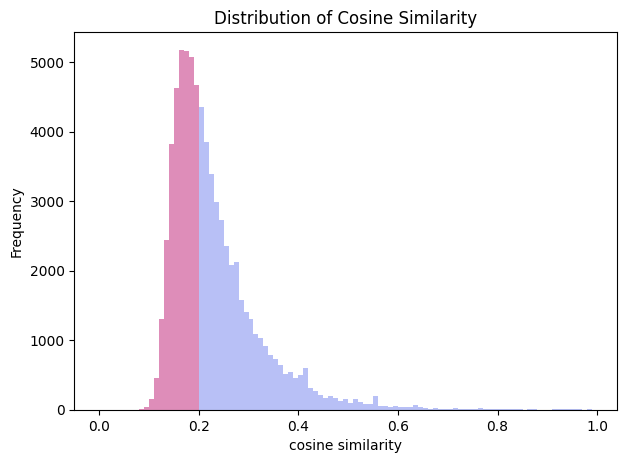

In [44]:
%matplotlib inline
mask1 = yellow_peril_data['cosine'] >= 0.20
mask2 = yellow_peril_data['cosine'] < 0.20
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
# Plot Histogram on x
plt.hist(yellow_peril_data.cosine[mask1], bins=arange(0,1,0.01) , color = colors[1])
plt.hist(yellow_peril_data.cosine[mask2], bins=arange(0,1,0.01), color = colors[0])
plt.gca().set(title='Distribution of Cosine Similarity', ylabel='Frequency', xlabel = 'cosine similarity');

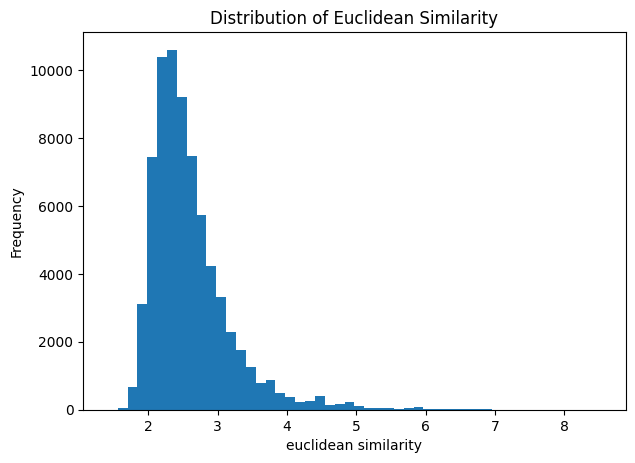

In [44]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
# Plot Histogram on x
plt.hist(yellow_peril_data['euclidean'], bins=50)
plt.gca().set(title='Distribution of Euclidean Similarity', ylabel='Frequency', xlabel = 'euclidean similarity');

In [28]:
keywords_mm = ['intelligent', 'hardworking', 'diligent', 'nothing', 'safe', 'math',
              'minority', 'behaved', 'smart', 'quiet', 'grit', 'nerd', 'shy', 'compliant',
              'nice', 'rich', 'sucessful', 'asian']

In [29]:
#find synonyms
super_model = []
for i in keywords_mm:
    if i in emb_dict.keys():
        temp = find_closest_embeddings(emb_dict[i])
        super_model.extend(temp)
    else:
        continue
        
super_model

['intelligent',
 'educated',
 'smart',
 'tend',
 'wise',
 'witty',
 'capable',
 'clever',
 'respectable',
 'hardworking',
 'hard-working',
 'talented',
 'respectful',
 'selfless',
 'supportive',
 'ambitious',
 'generous',
 'charismatic',
 'diligent',
 'hardworking',
 'prudent',
 'persistent',
 'vigorous',
 'righteous',
 'intelligent',
 'exemplary',
 'proverbs',
 'nothing',
 'anything',
 'something',
 'but',
 'everything',
 'there',
 'it',
 "n't",
 'else',
 'safe',
 'stay',
 'hope',
 'there',
 'good',
 'soon',
 'well',
 'keep',
 'home',
 'math',
 'maths',
 'physics',
 'exam',
 'biology',
 'chem',
 'algebra',
 'homework',
 'calculus',
 'minority',
 'minorities',
 'majority',
 'ethnic',
 'conservative',
 'conservatives',
 'democratic',
 'republican',
 'communities',
 'behaved',
 'behaving',
 'poorly',
 'mannered',
 'acted',
 'organised',
 'appropriately',
 'researched',
 'groomed',
 'smart',
 'stupid',
 'dumb',
 'cool',
 'clever',
 'intelligent',
 'way',
 'enough',
 'easy',
 'quiet',
 'si

In [74]:
mm = ['intelligent','educated','smart', 'capable','clever','respectable','hardworking','hard-working',
 'talented','respectful', 'ambitious', 'diligent', 'prudent', 'persistent', 'exemplary',
 'good', 'well', 'math','maths','algebra','calculus', 'minority','conservative', 'behaved', 
      'organised', 'quiet', 'silent', 'peaceful',
 'grit', 'determination','toughness', 'nerd','geek', 'nerds', 'nerdy','shy','quiet',
      'insecure', 'weird', 'compliant', 'nice', 'rich','wealthy', 'sucessful', 'asian']
model_minority = make_concept(mm, hydrated_data1)

KeyboardInterrupt: 

In [75]:
len(mm)

45

In [49]:
pd.set_option("display.max_colwidth", None)
mm_data = get_similarities(model_minority, filtered_glovetweet)
mm_data.head(10)

,tweet_id,cosine,euclidean,text,num_likes,date,author,Label
0,1243629129645395969,0.030580,1.656412,This is good and it's and it's good and it's also pretty good. https://t.co/6Qc8jqg4MR,0,2020-03-27 20:01:04,Gautraudd1,Counterhate
1,1240694400579076099,0.050047,3.907912,"@KyleClark Good, #WuhanVirus #ChineseVirus #ChinaVirus",0,2020-03-19 17:39:30,MolonLabeIII,Hate
2,1251045263294291968,0.050047,2.447628,@SkyNews Good #ChinaLiedPeopleDied,0,2020-04-17 07:10:08,bigknightywhu,Hate
3,1243523590294667264,0.050047,4.228995,@YRDeshmukh Too good! #ChineseVirus19 #ChineseVirus #ChinaVirus,0,2020-03-27 13:01:42,ndtrivedie,Hate
4,1250161521864433670,0.052973,2.621539,@peterbakernyt #ChineseVirus is better.\n#WuhanVirus is good.,1,2020-04-14 20:38:28,deb2nine,Hate
5,1243507594683125762,0.054584,2.099054,@philleehh Let’s hope this ages well - good luck #ChinaLiedPeopleDied #ChinaVirus,0,2020-03-27 11:58:08,HUDMotorsports,Hate
6,1242274727340605440,0.063194,3.026115,@BonnieGlaser Well well who’s a good little 🇨🇳 puppet now?\n\n#ChiNazi are lying\n\nAgain\n\n#ChinaLiedPeopleDied\n#WuhanVirus\n#COVID19\n\nhttps://t.co/HyMpL9bjbn https://t.co/pAxNQsyrnb,0,2020-03-24 02:19:10,qlee50,Hate
7,1244602705328263169,0.064830,2.671933,@CGTNOfficial well #ChineseVirus,0,2020-03-30 12:29:43,chaitudeveloper,Hate
8,1244824183990882304,0.064830,2.522879,Well well well\n@china https://t.co/GguStlw7KI,1,2020-03-31 03:09:47,AriCagan,Hate
9,1225175988088328192,0.067789,2.584709,This is really really good https://t.co/TjeDzir406 (and follow @chubailiang on China if you don't already),1,2020-02-05 21:54:52,ericbeebo,Hate


In [38]:
mm_data.to_csv("mm_data.csv")

In [32]:
top_model_minority = mm_data.loc[(mm_data.cosine < 0.20) & (mm_data.euclidean < 2.50)]
top_model_minority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 252
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   101 non-null    int64  
 1   cosine     101 non-null    float64
 2   euclidean  101 non-null    float64
 3   text       101 non-null    object 
 4   num_likes  101 non-null    int64  
 5   date       101 non-null    object 
 6   author     101 non-null    object 
 7   Label      101 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 7.1+ KB


In [33]:
#pickle
outfile = open('top_model_minority','wb')
pickle.dump(top_model_minority,outfile)
outfile.close()

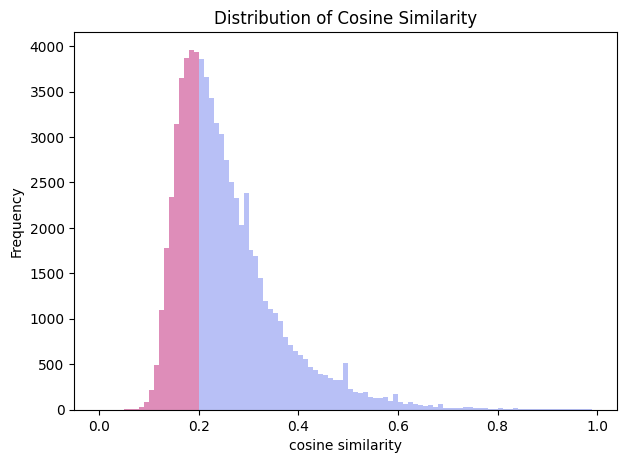

In [47]:
%matplotlib inline
mask1 = mm_data['cosine'] >= 0.20
mask2 = mm_data['cosine'] < 0.20
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
# Plot Histogram on x
plt.hist(mm_data.cosine[mask1], bins=arange(0,1,0.01) , color = colors[1])
plt.hist(mm_data.cosine[mask2], bins=arange(0,1,0.01), color = colors[0])
plt.gca().set(title='Distribution of Cosine Similarity', ylabel='Frequency', xlabel = 'cosine similarity');

## Covid Narratives

In [119]:
bioweapon_keywords = ['bioweapon', 'weapon', 'biology', 'lab', 'military', 'ccp', 'virologist', 'engineered', 'modified',
                     'wuhan', 'scientist', 'government', 'xijinping', 'gain', 'function', 'escape']
espionage_keywords = ['canada', 'research', 'stole', 'steal', 'lab', 'couple', 'laboratory', 'shipment', 'wuhan']
bat_keywords = ['bat', 'woman', 'eat', 'soup', 'contaminate']

In [120]:
bioweapon = make_concept(bioweapon_keywords, hydrated_data1)
bio_data = get_similarities(bioweapon, filtered_glovetweet)
bio_data.head(10)

,tweet_id,cosine,euclidean,text,num_likes,date,author,Label
0,1230931522087194625,0.107378,2.050742,@MBuhari But those 50 Nigerian students in #Wuhan #China was abondoned by your government. What a fuck up government you have 👎,0,2020-02-21 19:05:19,Georgi29,Hate
1,1233650479365668865,0.112247,2.037615,"@BernieSanders You are as dangerous as he is. Do you think China's authoritarian government has solved poverty? The Chinese government does not care about the reliability of the democratic system, so their government corruption cannot be controlled at all. https://t.co/jP4mgtyoRs",0,2020-02-29 07:09:29,zhengbaiting,Hate
2,1246608886704017409,0.120395,2.143065,"It's highlighting that the Chinese government, the authoritarian, Communist government of China, has sent more ventilators to New York than Donald Trump's government has. https://t.co/TR3OTS1n3j",0,2020-04-05 01:21:34,Twizznit,Hate
3,1238673359745044481,0.125534,2.147184,@danbowman @Heminator @baseballcrank It's xenophobic to talk about the Chinese government claiming the virus is a US government/military conspiracy that was planted in Wuhan?,0,2020-03-14 03:48:37,InfinityBall,Counterhate
4,1246410238875615233,0.131585,2.211865,@weijia How much is the Chinese government paying you. Wuhan virus is biological weapon from your Chinese government.,0,2020-04-04 12:12:12,CyranJoseph,Hate
5,1251158228362096641,0.131695,2.203818,@CNN The Government that mismanaged this Virus is the Chinese Communist Party Government. Period. https://t.co/8nsPVVzOhu,2,2020-04-17 14:39:01,BamaJoe3,Hate
6,1238465025070653440,0.135097,2.279892,@GordonGChang @newtgingrich The Chinese government is the most evil government. CCP Virus.,2,2020-03-13 14:00:46,Lin99659395,Hate
7,1242829521193058304,0.140486,2.263373,Few Scientist claiming that the virus is a biochemical weapon produced by the communist government of China and Chinese military,0,2020-03-25 15:03:43,Rajpand40778174,Hate
8,1246552681134596101,0.141297,2.284615,@SenRickScott @WHO WHO works for China communist government. #BoycottChina #CCP_is_terrorist,1,2020-04-04 21:38:13,Ignacio83647327,Hate
9,1245517916973322241,0.141887,2.273821,"@IamAaaditya @China_Amb_India Who tells you that they are not honest? the media? Your government? In January,Chinese government has told your government to prepare for the virus after China's publishing lock down https://t.co/k1PRdgRUK4 what your government doing during these three months? blame? complain?",0,2020-04-02 01:06:26,tiktokseller,Hate


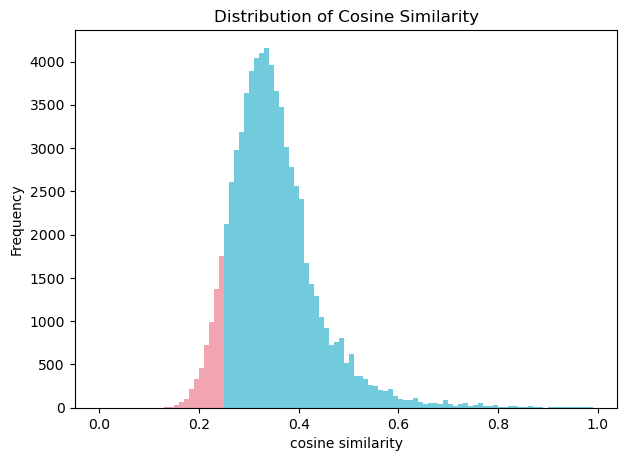

In [178]:
colors = np.array(Moonrise1_5.mpl_colors)
%matplotlib inline
mask1 = bio_data['cosine'] >= 0.25
mask2 = bio_data['cosine'] < 0.25
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
# Plot Histogram on x
plt.hist(bio_data.cosine[mask1], bins=arange(0,1,0.01) , color = colors[0])
plt.hist(bio_data.cosine[mask2], bins=arange(0,1,0.01), color = colors[1])
plt.gca().set(title='Distribution of Cosine Similarity', ylabel='Frequency', xlabel = 'cosine similarity');

In [121]:
espionage = make_concept(espionage_keywords, hydrated_data1)
esp_data = get_similarities(espionage, filtered_glovetweet)
esp_data.head(10)

,tweet_id,cosine,euclidean,text,num_likes,date,author,Label
0,1241344109249347585,0.178643,2.362082,@MediaScourge @rose_k01 #ChinaVirus is come from Wuhan Lab.,0,2020-03-21 12:41:13,EdronChk,Hate
1,1223683277959106562,0.183617,2.296407,Not to suggest this escaped from the Wuhan Lab. https://t.co/ixKTiIukeq,0,2020-02-01 19:03:23,CharleyTakaya,Hate
2,1246562001431801856,0.183644,2.382798,"@kirstiealley Actually, a virus from Wuhan lab.",0,2020-04-04 22:15:15,wynburn1Wynburn,Hate
3,1240266627360280577,0.190485,2.322743,"@glesgapaul @laserlipstick @piersmorgan It’s Wuhanvirus, created in a lab at Wuhan China.",0,2020-03-18 13:19:41,KloriaD,Hate
4,1239958810162167811,0.198730,2.736653,@hemstrought @ACTBrigitte https://t.co/FyAgc8WFXU\n\n#Chinazi made the #coronavirus in #Wuhan P4 lab. #ChinaVirus #AntiCCP,0,2020-03-17 16:56:32,liescost,Hate
5,1249840618454597637,0.198771,2.616369,@peterbakernyt That is where it came from...Virology sbl4 lab in Wuhan China = #WuhanVirus #WuhanFlu,2,2020-04-13 23:23:19,ACT519,Hate
6,1222713147179450368,0.201688,2.383720,"""The Chinese agents have stolen the coronavirus from Canadian lab:""\n""And upgraded it into a bioweapon at the lab in Wuhan:""",0,2020-01-30 02:48:25,kj666japan,Hate
7,1229437128783941634,0.209050,2.506513,Wuhan lab ain’t nothing to eff with. https://t.co/VyVaTc7YrW,9,2020-02-17 16:07:07,CarlfrmPeaRidge,Hate
8,1240407291737698305,0.216426,2.477615,@kenoath58 @COsweda @CeciliaVega @realDonaldTrump I like it. The CCP Wuhan Lab Virus🇨🇳 🧫 🦠,4,2020-03-18 22:38:38,Steve3556,Hate
9,1245562385378705415,0.217407,2.505035,"@SenTomCotton @coinabs @TuckerCarlson How does Zhengli-Li Shi, Key Laboratory of Special Pathogens and Biosafety, Wuhan Institute of Virology, Chinese Academy of Sciences, Wuhan, China get access to a @UNC BSL 3 lab and the China is allowed to purchase a virus from their in 2015?",0,2020-04-02 04:03:08,franklion2014,Hate


In [122]:
bat = make_concept(bat_keywords, hydrated_data1)
bat_data = get_similarities(bat, filtered_glovetweet)
bat_data.head(10)

,tweet_id,cosine,euclidean,text,num_likes,date,author,Label
0,1248225752367144964,0.070705,2.598402,EAT THIS ☝️ https://t.co/56kZ8VbBUt,0,2020-04-09 12:26:24,DamienBouvier2,Counterhate
1,1240998156181143555,0.070705,3.040632,eat that. https://t.co/TCzVwITHBs,0,2020-03-20 13:46:31,siapasahla,Hate
2,1224491302387142661,0.088296,2.845661,Eat bat soup you racists! #WokePatrol https://t.co/WQ3H9QvpdJ,0,2020-02-04 00:34:11,Dmess16,Hate
3,1240548426275852288,0.105226,2.542250,@mikemchargue @realDonaldTrump Chinese virus! Go eat a bat!,1,2020-03-19 07:59:27,Sarge1208,Hate
4,1243759873793368064,0.105308,2.758292,@dwnews Keep eating bat soup. #ChineseVirus,4,2020-03-28 04:40:36,federico_123456,Hate
5,1223384123366105088,0.107999,2.597102,"@Potato88243113 @ItsPurplexx_ @LilJenixie @softiemaria @MoonuliiRBLX They don’t eat anything, they eat exotic animals. It might not be normal, but they got coronavirus from something they weren’t supposed to eat from the bat",5,2020-01-31 23:14:39,alixiaworm,Hate
6,1249228807115919361,0.111980,2.865202,"@Y_winwin If you have food to eat, you probably do not eat bats, and spread covid 19 to the world like this",0,2020-04-12 06:52:11,Jame88655402,Hate
7,1238721694069485574,0.112010,2.729318,"Wuhan people: hold my beer. No need to eat pork first, let's eat the bat instead. https://t.co/s2JQUDPiyY",0,2020-03-14 07:00:40,ajiwar,Hate
8,1249724235880083456,0.112716,2.769196,@xixi_lover @Perciaaa1 Chinese people only eat bat. #ChineseVirus,0,2020-04-13 15:40:51,john_smith7865,Hate
9,1227056919241605122,0.114147,2.633327,@mimian2009 @bouta_nt Good you eat your veggies and ill have steak! Go to China and tell them how to eat their food . https://t.co/ooa6diW4Hd,0,2020-02-11 02:29:01,Pc_Free_Zone,Hate


### Counterhate Only

In [60]:
counterhate_data = hydrated_data1[hydrated_data1.Label == 'Counterhate']

In [61]:
counterhate_glove = glove_tweets2[glove_tweets2.tweet_id.isin(counterhate_data.tweet_id)]

In [62]:
glovecounter_dict0 = counterhate_glove.set_index('tweet_id').to_dict()[0]
for key, value in glovecounter_dict0.items():
    glovecounter_dict0[key] = glovecounter_dict0[key].flatten()

counter_glove_dict = {k: v for k, v in glovecounter_dict0.items() if v != []}

<ipython-input-62-e90587bfd696>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  counter_glove_dict = {k: v for k, v in glovecounter_dict0.items() if v != []}
<ipython-input-62-e90587bfd696>:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  counter_glove_dict = {k: v for k, v in glovecounter_dict0.items() if v != []}


In [63]:
mm_counterhate = make_concept(mm, counterhate_data)
pd.set_option("display.max_colwidth", None)
mm_counterhate_data = get_similarities(mm_counterhate, counter_glove_dict)
mm_counterhate_data.sort_values('euclidean').head(10)

,tweet_id,cosine,euclidean,text,num_likes,date,author,Label
1,1240861491756183557,0.075915,2.047637,"@Breaking911 If you don’t know the difference in what was said about it being a Chinese virus and the fact that you’re Asian, well, I just feel really bad for you. Get well soon.",0,2020-03-20 04:43:28,JanisSt86035425,Counterhate
2,1233810188257370117,0.080595,2.082850,Well that’s exactly how Asians who ain’t even Chinese or who don’t live in China feel. Still a nice beer tho 🤣🤷🏽‍♀️ https://t.co/XzEXGbvj2S,0,2020-02-29 17:44:06,vannahtho,Counterhate
3,1248869816242507776,0.089216,2.205345,"@mrjules07 @Stahpslay @mehdirhasan I said we're progressing, or do you actually think that calling it the Chinese virus is a good thing for Asian people living in the US?",0,2020-04-11 07:05:41,Rrubinski1,Counterhate
4,1245246696763711488,0.089991,2.225206,"@MewsuppasitTH Although we are far away in China, Chinese fans will always support you. At the same time, we hope you can get better and better (sorry, my English is not very good). Finally, I want to tell you that I like you and you are very handsome",6,2020-04-01 07:08:42,Y2BC6Mxa5KicPf7,Counterhate
5,1240672800173686784,0.092941,2.252214,". @quononqua not sure why you would say this shit in the first place because chinese/asian people are NOT the source of the corona virus. this may have been a joke but its not okay whatsoever to be racist like this. from a fellow usci student to another, be a better person https://t.co/WYpwAiBRNs",15,2020-03-19 16:13:40,maddyymorales,Counterhate
0,1243629129645395969,0.060358,2.260006,This is good and it's and it's good and it's also pretty good. https://t.co/6Qc8jqg4MR,0,2020-03-27 20:01:04,Gautraudd1,Counterhate
6,1247732011156078593,0.096269,2.300297,Good to know where you guys stand and contributing to the xenophobia of Chinese and Asian Americans. I won’t PAY a cent to you ever and I hope my friends won’t either after reading your tweets. https://t.co/Z0HttYqiqL,4,2020-04-08 03:44:27,jungnanhkang,Counterhate
8,1251162762731909121,0.099054,2.310436,@MainEventTV_AKA Oh I know and it's pretty much all the Asian countries are racist to some degree. China on the other hand takes it too far.,0,2020-04-17 14:57:02,RogueSkyte,Counterhate
11,1238831298896158728,0.102501,2.337008,"As much as #coronavirus may well show us the bad in humanity (toilet rolls), it will sure also show us the good as well. Shame we all gotta start dying before we treat each other well though.",0,2020-03-14 14:16:12,Dcrad,Counterhate
17,1236515745133211649,0.104242,2.364781,"@Annubisking @KALONSMERALDO @kimlorenn Black.. Asian Arabic we all support and do racism cause the world is just a huge piece of shit It's not the first time a thing like this happens and we be like \n""Oh no ! End of the world Coronavirus is made by Chinese""\n\nI mean look at the Arabic they were all treated to same",0,2020-03-08 04:55:01,WSouls70,Counterhate


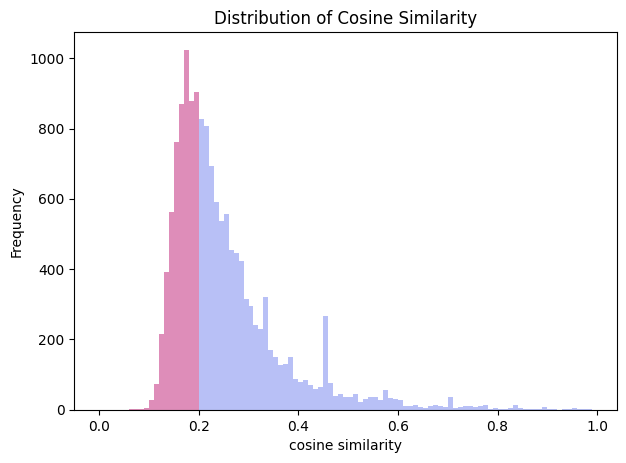

In [64]:
%matplotlib inline
mask1 = mm_counterhate_data['cosine'] >= 0.20
mask2 = mm_counterhate_data['cosine'] < 0.20
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
# Plot Histogram on x
plt.hist(mm_counterhate_data.cosine[mask1], bins=arange(0,1,0.01) , color = colors[1])
plt.hist(mm_counterhate_data.cosine[mask2], bins=arange(0,1,0.01), color = colors[0])
plt.gca().set(title='Distribution of Cosine Similarity', ylabel='Frequency', xlabel = 'cosine similarity');

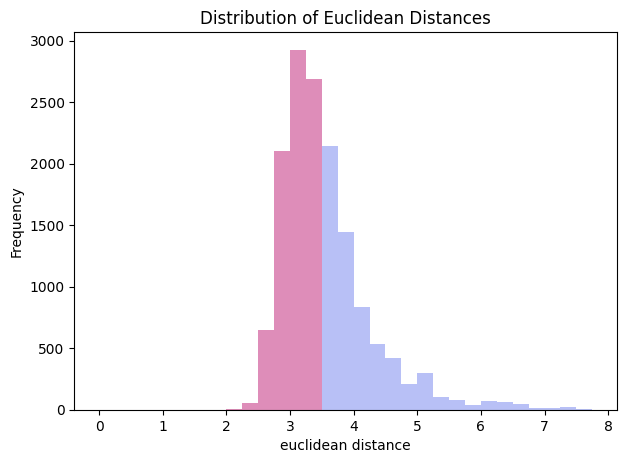

In [65]:
%matplotlib inline
mask1 = mm_counterhate_data['euclidean'] >= 3.5
mask2 = mm_counterhate_data['euclidean'] < 3.5
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
# Plot Histogram on x
plt.hist(mm_counterhate_data.euclidean[mask1], bins=arange(0,8,0.25) , color = colors[1])
plt.hist(mm_counterhate_data.euclidean[mask2], bins=arange(0,8,0.25), color = colors[0])
plt.gca().set(title='Distribution of Euclidean Distances', ylabel='Frequency', xlabel = 'euclidean distance');

In [66]:
top_counterhate_mm = mm_counterhate_data.loc[(mm_counterhate_data.cosine < 0.20) & (mm_counterhate_data.euclidean < 2.5)]

In [67]:
#pickle
outfile = open('top_counterhate_mm','wb')
pickle.dump(top_counterhate_mm,outfile)
outfile.close()

In [71]:
yellow_peril_counter = make_concept(yellow_peril, counterhate_data)
yp_counter_data = get_similarities(yellow_peril_counter, counter_glove_dict)
yp_counter_data.head(20)

,tweet_id,cosine,euclidean,text,num_likes,date,author,Label
0,1249396842405781511,0.076421,1.754625,"#COVID19 is from BATS! Following #BillMaher’s “logic” it wld be “BatFlu”. He took #Trump race-baiting &amp; very real Chinese ppl are being physically attacked, spit upon &amp; made to be afraid because of racist stereotyoes driven by this ignorance. Enough! Racism is a deadly disease! https://t.co/pCZS2OBXkW",1406,2020-04-12 17:59:54,mayawiley,Counterhate
1,1240433227594108929,0.080176,1.632571,@realDonaldTrump STOP CALLING IT THE CHINESE VIRUS. You know the right Name-Use it. Your purposeful bigoted behavior is uncalled and dangerous and that will not be tolerated. You have already lied to us about the Virus. You are a weak and foolish coward and don't know how to be a leader.,0,2020-03-19 00:21:42,lcwerenz,Counterhate
2,1240743971162337290,0.082897,1.668241,"What he is calling the disease is VERY important! It leads small minded morons to link A VIRUS to Chinese people, which puts them in danger from morons who will use the ""virus"" as a reason to hurt &amp;/or kill innocent people.\n\nWhat he's doing needs to be talked about. Fuck off. https://t.co/wuJ3deWljG",3,2020-03-19 20:56:29,TaniaMarie20,Counterhate
3,1239745056958906369,0.082976,1.668531,This is honestly disgusting that the leader of our Nation is being so ignorant and racist to call this pandemic “the Chinese Virus”. I usually keep my mouth shut when it comes to politics but when this type of xenophobia is shown by our president it should be called out as wrong. https://t.co/jD4Ac1X6b0,2,2020-03-17 02:47:09,StephTweeted_,Counterhate
4,1243354605032898560,0.083919,1.683113,Words matter. Calling it “Chinese virus” only incites hatred &amp; violence toward Asians everywhere while not doing a thing to hold CCP accountable for their coverup &amp; failure to act until outbreak became a pandemic. \n\nBe kind. Don’t be a racist asshole.\n\nhttps://t.co/SDg7vtdGqz,3,2020-03-27 01:50:12,JewishDem,Counterhate
5,1229528411388825602,0.084181,1.686393,"What the actual fuck!!?? This “ancient Chinese medicine” bullshit has got to stop, it’s arrogant, it’s hubris and it’s a load of old balls. The fact that it’s driving so many species to extinction should be reason enough to stamp it out! https://t.co/noyiooJJos",0,2020-02-17 22:09:51,TheMercOctavius,Counterhate
6,1222808864170528768,0.086727,1.899865,I hate how white people are using this coronavirus thing to be racist towards asian people. talking about they’re afraid to get a “disease” FIRST OF ALL YALL WERE THE ONES WHO BROUGHT MULTIPLE DISEASES TO A WHOLE COUNTRY \nHOW FUCKING DARE YOU,1,2020-01-30 09:08:46,thisiskori,Counterhate
7,1240443732136247297,0.087305,1.751793,how fucking irresponsible to call the covid19 the chinese virus\nhow despicable and dangerous\n\nppl are already getting hurt and it'll only escalate,9,2020-03-19 01:03:26,voyahora,Counterhate
8,1240750998324252672,0.087743,1.712988,"@Upton1000 Ur ignorance is displayed, to extent that U attack sum1 4 his use of word fuck. However, you are not as intelligent as you think, calling Covid19/Corona Virus the Chinese Virus makes me fucking sick. It's causing physical harm 2 Asian Americans. Stop FUCKing saying it NOW!",2,2020-03-19 21:24:24,loyaldogloverRB,Counterhate
9,1240399199361028098,0.087841,1.819873,"@JoeMAGA20 @IvankaTrump Dems hate? Trump is the one calling this the “Chinese virus”...causing more fear against one group of people. All that man does is hate. He is such an awful, hateful, disgusting, little “man”!",0,2020-03-18 22:06:29,LkaultLori,Counterhate


### Hate Tweets Only

In [51]:
hate_data = hydrated_data1[hydrated_data1.Label == 'Hate']
hate_glove = glove_tweets2[glove_tweets2.tweet_id.isin(hate_data.tweet_id)]

In [52]:
glovecounter_dict0 = hate_glove.set_index('tweet_id').to_dict()[0]
for key, value in glovecounter_dict0.items():
    glovecounter_dict0[key] = glovecounter_dict0[key].flatten()

hate_glove_dict = {k: v for k, v in glovecounter_dict0.items() if v != []}

<ipython-input-52-dfc998112891>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  hate_glove_dict = {k: v for k, v in glovecounter_dict0.items() if v != []}
<ipython-input-52-dfc998112891>:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  hate_glove_dict = {k: v for k, v in glovecounter_dict0.items() if v != []}


In [53]:
yellow_peril_hate = make_concept(yellow_peril, hate_data)
yp_hate_data = get_similarities(yellow_peril_hate, hate_glove_dict)
yp_hate_data.head(10)

,tweet_id,cosine,euclidean,text,num_likes,date,author,Label
0,1250165712510992390,0.073498,1.443786,"China is guilty of the scientist's death, murdered file burning, what the hell is this country? That kills his fellow man, that eats dogs, bats, snakes, mice, this communist government will NOT change, our ideals, how many people are dying because Chinese virus! @EmbaixadaChina https://t.co/xP75xpWoIl",0,2020-04-14 20:55:07,JeffersonMotiz3,Hate
1,1249644362801258503,0.086448,1.588761,@glimmerz6 @Isaack_wambua @AfricaFactsZone Of course that’s what a commie government would say. First they say said American soldiers gave it to China. It’s chink virus. Kung flu. End of story. I’m not listening to some communist piece of shit who eats dogs and bats. I will always hate chinks because you people are filthy,1,2020-04-13 10:23:28,AndSteptoe,Hate
2,1243800616931135488,0.087377,1.555012,"You suck, #coronavirus, #CoronaLockdown, #ChineseVirus, #ChineseWuhanVirus, #ChinaLiedAndPeopleDied, #ChinaVirus! If China was honest and not a stupid corrupt Communist party, I wouldn't be in this pain in the ass, and neither would any of the other innocent Americans! @GovMLG https://t.co/USLF1QAeE6",0,2020-03-28 07:22:30,NMCovid19,Hate
3,1251183753948430336,0.089420,1.536913,"Lindsay, this is the first time you have said something that makes sense. The chinks are responsible for this epidemic cause by the yellow chink China virus 🦠, which has infected 2.2 millions; killed 175000. These idol worshipers eat unclean animals like dogs, cats, bats, rats!! https://t.co/VzA3e2v6Fq",0,2020-04-17 16:20:27,weatherspoonro1,Hate
4,1250800744028090374,0.090432,1.544043,"@PamelaGeller 1/2\nWithout an iota of doubt the moment Wuhan virus was exposed. Chinese lied &amp; blamed voiceless bats, rats, dogs, cats, snakes &amp; all the living creatures they eat while the animals are still alive. The question is, will international community hold China accountable for coverup?",0,2020-04-16 14:58:30,kusumvyasusa,Hate
5,1250740355756167169,0.096459,1.604750,@WIONews @palkisu The greedy Chinese will eradicate all nature and animals! They have no value for any form of life! Treating animals and subjecting them to the worst kind of torture.The world must stand against these bat/dog/snake/eating evil people!! @WHO #ccp #WuhanVirus #ChinaVirus,0,2020-04-16 10:58:33,Janvee37263751,Hate
6,1239911945764921344,0.096758,1.784119,"@zlj517 #fuckchina, they eat dogs and cats , burn them alive before. They eat mice, bats. They need to stop their barbaric behaviors, the most CRUEL country in terms of animal rights and they don’t give a shit about the environment too. Chinese government must make such things illegal",69,2020-03-17 13:50:18,I_am_Cecil_too,Hate
7,1250236065752821766,0.096759,1.616136,"@meShirshendu Chinese history of rulers,dictators tell the truth like tianmen square carnage..by Communist politburo leaders.Chinese Communist party are habitual offenders to kill their own peoples,spread the virus worldwide&amp;eat bats,dogs&amp;live animals. Thoo on China &amp; those who supports.",1,2020-04-15 01:34:40,Doc_Amritendu,Hate
8,1245222717747576833,0.096831,1.620120,@Julie48370369 @zlj517 You’re as blind as the bat in CHINA that caused this whole pandemic. Down with the Chinese Communist Government! 🔥 🇨🇳 🔥 (y’all wish your emoji game is on fleek like mine) you commie pigs!,1,2020-04-01 05:33:25,KwangWynn,Hate
9,1244766560419483656,0.098562,1.611545,"China is EVIL Communist Country. #WuhanVirus killed many people, and shitbird communists covered it up. Has NOTHING to do with race, so STFU! #ChinaLiedPeopleDie https://t.co/0md8JBNjjp",2,2020-03-30 23:20:49,OccamsRazorCuts,Hate


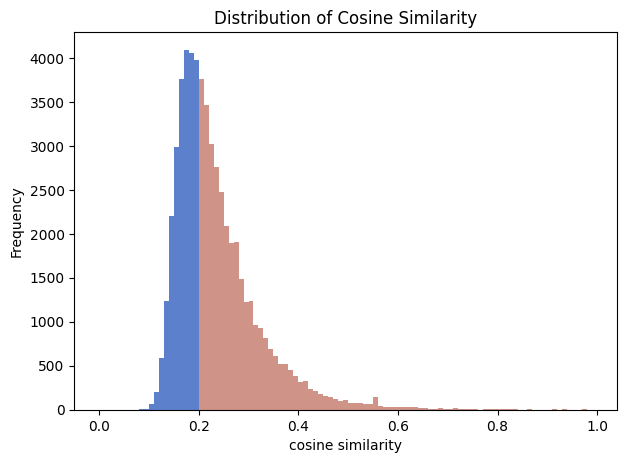

In [56]:
%matplotlib inline
mask1 = yp_hate_data['cosine'] >= 0.20
mask2 = yp_hate_data['cosine'] < 0.20
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
# Plot Histogram on x
plt.hist(yp_hate_data.cosine[mask1], bins=arange(0,1,0.01) , color = colors[2])
plt.hist(yp_hate_data.cosine[mask2], bins=arange(0,1,0.01), color = colors[3])
plt.gca().set(title='Distribution of Cosine Similarity', ylabel='Frequency', xlabel = 'cosine similarity');

In [57]:
top_peril_hate = yp_hate_data.loc[(yp_hate_data.cosine < 0.20) & (yp_hate_data.euclidean < 2.5)]

In [58]:
top_peril_hate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20395 entries, 0 to 23184
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   20395 non-null  int64  
 1   cosine     20395 non-null  float64
 2   euclidean  20395 non-null  float64
 3   text       20395 non-null  object 
 4   num_likes  20395 non-null  int64  
 5   date       20395 non-null  object 
 6   author     20395 non-null  object 
 7   Label      20395 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 1.4+ MB


In [108]:
#pickle
outfile = open('top_peril_hate','wb')
pickle.dump(top_peril_hate,outfile)
outfile.close()

In [41]:
model_minority_hate = make_concept(keywords_mm, hate_data)
mm_hate_dist = find_euclidean(model_minority_hate, hate_glove_dict)
topmm_hate = (pd.merge(mm_hate_dist, hate_data, how = 'left', on = 'tweet_id')
                       .sort_values('distance')
                    )
topmm_hate.head(20)

,tweet_id,distance,text,num_likes,date,author,Label
0,1235170257179832320,2.190537,"However, after knowing this, America did nothing except for bashing China and Chinese Govt, for now, America still doing nothing meaningful, Good luck bro, Good luck https://t.co/Tt8ec08pij",2,2020-03-04 11:48:32,Dreamershuo,Hate
1,1242997070920855552,2.214079,@LizSly @jaketapper Which means nothing since China hasn’t told the truth about anything yet! #ChinaLiedPeopleDied,0,2020-03-26 02:09:30,ConservaTed_Fla,Hate
2,1243263864659042305,2.231152,@MacaesBruno Except #ChineseVirus nothing else work from #China,1,2020-03-26 19:49:38,TheekHai11,Hate
3,1242831124058923009,2.272093,@majorgauravarya Nothing else #ChineseVirus,0,2020-03-25 15:10:05,sumitp191,Hate
4,1247048639802789889,2.313285,@DrTedros @UNmigration Your feel good tweets mean nothing knowing that you’re a tool to the #CCPVirus spread. Boo! https://t.co/b0n7USDALt,0,2020-04-06 06:28:59,daffodilcat9429,Hate
5,1244822280321921024,2.330091,"There is something seriously wrong with China. Nowhere in the world, i repeat, nowhere in the world, have communist governments ever done anything for the greater good! There has always been destruction and trouble with them around! https://t.co/xA4xAp6DGb",2,2020-03-31 03:02:13,doc_kinju,Hate
6,1240839627939799041,2.332217,@WhiteHouse Yes because knowing it as the Chinese virus is very important to stay safe,0,2020-03-20 03:16:35,KesoAndKern,Hate
7,1235198831693664256,2.334850,"this whole coronavirus thing is absolutely insane, people really need to leave the chinese people alone, it wasn’t their fault that this is a thing cause nobody expects something to have some new disease that was never heard of",1,2020-03-04 13:42:05,lionwastaken,Hate
8,1223067074588594177,2.335917,"Haha, You guys are wake, which only play your tricky words. No matter what you say, nothing could stop China to be a great and peaceful super power like hundred years ago. Your words are meaningless. https://t.co/psZpSc0mkw",0,2020-01-31 02:14:48,Dreamershuo,Hate
9,1239939304723566592,2.340464,"@NikkiHaley Anything Chinese made is of poor quality therefore temporary, nothing different about their virus. Calm down it is temporary!!",3,2020-03-17 15:39:01,MichaelGebremar,Hate


In [42]:
bioweapon_keywords = ['bioweapon', 'weapon', 'biology', 'lab', 'military', 'ccp', 'virologist', 'engineered', 'modified',
                     'wuhan', 'scientist', 'government', 'xijinping', 'gain', 'function', 'escape']
espionage_keywords = ['canada', 'research', 'stole', 'steal', 'lab', 'couple', 'laboratory', 'shipment', 'wuhan']
bat_keywords = ['bat', 'woman', 'eat', 'soup', 'contaminate']

In [43]:
bioweapon_hate = make_concept(bioweapon_keywords, hate_data)
bw_hate_dist = find_euclidean(bioweapon_hate, hate_glove_dict)
topbw_hate = (pd.merge(bw_hate_dist, hate_data, how = 'left', on = 'tweet_id')
                       .sort_values('distance')
                    )
topbw_hate.head(20)

,tweet_id,distance,text,num_likes,date,author,Label
0,1230931522087194625,2.029669,@MBuhari But those 50 Nigerian students in #Wuhan #China was abondoned by your government. What a fuck up government you have 👎,0,2020-02-21 19:05:19,Georgi29,Hate
1,1233650479365668865,2.030597,"@BernieSanders You are as dangerous as he is. Do you think China's authoritarian government has solved poverty? The Chinese government does not care about the reliability of the democratic system, so their government corruption cannot be controlled at all. https://t.co/jP4mgtyoRs",0,2020-02-29 07:09:29,zhengbaiting,Hate
2,1246608886704017409,2.123201,"It's highlighting that the Chinese government, the authoritarian, Communist government of China, has sent more ventilators to New York than Donald Trump's government has. https://t.co/TR3OTS1n3j",0,2020-04-05 01:21:34,Twizznit,Hate
3,1246410238875615233,2.185104,@weijia How much is the Chinese government paying you. Wuhan virus is biological weapon from your Chinese government.,0,2020-04-04 12:12:12,CyranJoseph,Hate
4,1251158228362096641,2.190862,@CNN The Government that mismanaged this Virus is the Chinese Communist Party Government. Period. https://t.co/8nsPVVzOhu,2,2020-04-17 14:39:01,BamaJoe3,Hate
5,1242829521193058304,2.224555,Few Scientist claiming that the virus is a biochemical weapon produced by the communist government of China and Chinese military,0,2020-03-25 15:03:43,Rajpand40778174,Hate
6,1245517916973322241,2.246234,"@IamAaaditya @China_Amb_India Who tells you that they are not honest? the media? Your government? In January,Chinese government has told your government to prepare for the virus after China's publishing lock down https://t.co/k1PRdgRUK4 what your government doing during these three months? blame? complain?",0,2020-04-02 01:06:26,tiktokseller,Hate
7,1248918088910688261,2.259124,@PaulineHansonOz I have always quested the chinese communist party roll in this virus and the world government should seek compensation as all chinese investment should be seized by government,0,2020-04-11 10:17:30,bazzauz,Hate
8,1246552681134596101,2.259671,@SenRickScott @WHO WHO works for China communist government. #BoycottChina #CCP_is_terrorist,1,2020-04-04 21:38:13,Ignacio83647327,Hate
9,1238465025070653440,2.269901,@GordonGChang @newtgingrich The Chinese government is the most evil government. CCP Virus.,2,2020-03-13 14:00:46,Lin99659395,Hate


In [44]:
espionage_hate = make_concept(espionage_keywords, hate_data)
esp_hate_dist = find_euclidean(espionage_hate, hate_glove_dict)
topesp_hate = (pd.merge(esp_hate_dist, hate_data, how = 'left', on = 'tweet_id')
                       .sort_values('distance')
                    )
topesp_hate.head(20)

,tweet_id,distance,text,num_likes,date,author,Label
0,1223683277959106562,2.332233,Not to suggest this escaped from the Wuhan Lab. https://t.co/ixKTiIukeq,0,2020-02-01 19:03:23,CharleyTakaya,Hate
1,1240266627360280577,2.368858,"@glesgapaul @laserlipstick @piersmorgan It’s Wuhanvirus, created in a lab at Wuhan China.",0,2020-03-18 13:19:41,KloriaD,Hate
2,1241344109249347585,2.404672,@MediaScourge @rose_k01 #ChinaVirus is come from Wuhan Lab.,0,2020-03-21 12:41:13,EdronChk,Hate
3,1222713147179450368,2.407137,"""The Chinese agents have stolen the coronavirus from Canadian lab:""\n""And upgraded it into a bioweapon at the lab in Wuhan:""",0,2020-01-30 02:48:25,kj666japan,Hate
4,1246562001431801856,2.411565,"@kirstiealley Actually, a virus from Wuhan lab.",0,2020-04-04 22:15:15,wynburn1Wynburn,Hate
5,1240407291737698305,2.503212,@kenoath58 @COsweda @CeciliaVega @realDonaldTrump I like it. The CCP Wuhan Lab Virus🇨🇳 🧫 🦠,4,2020-03-18 22:38:38,Steve3556,Hate
6,1220799770496839682,2.508273,"Inside the in the Wuhan, China lab poised to study world's most dangerous pathogens...the lab really does exist!\n\nhttps://t.co/W6rZKQEVim https://t.co/W6rZKQEVim",2,2020-01-24 20:05:21,JulEStan1,Hate
7,1229437128783941634,2.533462,Wuhan lab ain’t nothing to eff with. https://t.co/VyVaTc7YrW,9,2020-02-17 16:07:07,CarlfrmPeaRidge,Hate
8,1250140136656064513,2.538275,"@piersmorgan @Hayley_Barlow Start asking about the Wuhan Lab. Not the wet market, The Lab #WuhanVirus",1,2020-04-14 19:13:29,Pops_Powell,Hate
9,1245562385378705415,2.541272,"@SenTomCotton @coinabs @TuckerCarlson How does Zhengli-Li Shi, Key Laboratory of Special Pathogens and Biosafety, Wuhan Institute of Virology, Chinese Academy of Sciences, Wuhan, China get access to a @UNC BSL 3 lab and the China is allowed to purchase a virus from their in 2015?",0,2020-04-02 04:03:08,franklion2014,Hate


In [45]:
bat_hate = make_concept(bat_keywords, hate_data)
bat_hate_dist = find_euclidean(bat_hate, hate_glove_dict)
topbat_hate = (pd.merge(bat_hate_dist, hate_data, how = 'left', on = 'tweet_id')
                       .sort_values('distance')
                    )
topbat_hate.head(20)

,tweet_id,distance,text,num_likes,date,author,Label
0,1240548426275852288,2.549960,@mikemchargue @realDonaldTrump Chinese virus! Go eat a bat!,1,2020-03-19 07:59:27,Sarge1208,Hate
1,1223384123366105088,2.635916,"@Potato88243113 @ItsPurplexx_ @LilJenixie @softiemaria @MoonuliiRBLX They don’t eat anything, they eat exotic animals. It might not be normal, but they got coronavirus from something they weren’t supposed to eat from the bat",5,2020-01-31 23:14:39,alixiaworm,Hate
2,1227056919241605122,2.680539,@mimian2009 @bouta_nt Good you eat your veggies and ill have steak! Go to China and tell them how to eat their food . https://t.co/ooa6diW4Hd,0,2020-02-11 02:29:01,Pc_Free_Zone,Hate
3,1221148318773977088,2.751810,"If you eat soup with a bat in it, you deserve to get Coronavirus.",27,2020-01-25 19:10:21,BeatinTheBookie,Hate
4,1250244828400701442,2.756687,@amnestyusa Eat shit. #WuhanVirus,0,2020-04-15 02:09:30,GeekbotMedia,Hate
5,1238721694069485574,2.759689,"Wuhan people: hold my beer. No need to eat pork first, let's eat the bat instead. https://t.co/s2JQUDPiyY",0,2020-03-14 07:00:40,ajiwar,Hate
6,1243759873793368064,2.761338,@dwnews Keep eating bat soup. #ChineseVirus,4,2020-03-28 04:40:36,federico_123456,Hate
7,1249724235880083456,2.795717,@xixi_lover @Perciaaa1 Chinese people only eat bat. #ChineseVirus,0,2020-04-13 15:40:51,john_smith7865,Hate
8,1224491302387142661,2.840896,Eat bat soup you racists! #WokePatrol https://t.co/WQ3H9QvpdJ,0,2020-02-04 00:34:11,Dmess16,Hate
9,1250198218031468544,2.843804,@wuhan You have your bat soup and go to sleep! \n\n#WuhanVirus,0,2020-04-14 23:04:17,NanaInThames,Hate
